In [1]:
#Imports
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
from scipy import stats
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
#Read data
df = pd.read_csv("../../Data/openpowerlifting-2021-03-31-ab223798.csv", index_col = 0)

C:\Users\Joe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (31,33,35,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 1. Data quality

First inspect data quality (missingness, erroneous entries, variable types, etc.). Note the lifter name is the index. Documentation of the metadata is available at https://openpowerlifting.gitlab.io/opl-csv/bulk-csv-docs.html

In [4]:
#df.head()
#df.shape
#df.columns
#df.dtypes.value_counts()
#df.describe()
#df.info()

2,419,464 observations, 40 rows (22 numeric, 18 categorical). Since our response variable/s will depend on the question being answered, we won't separate any response variables at this time. But we can separate categorical/numeric variables.

In [3]:
#Split data by numeric/categorical
Xnum = df[df.columns[df.dtypes != object]]
Xcat = df[df.columns[df.dtypes == object]]

### Missing data

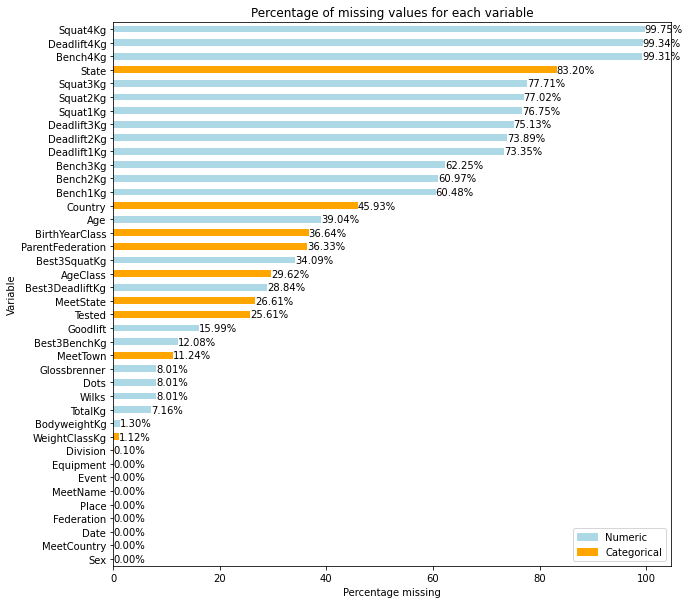

In [6]:
#Calculate percentage of nulls for each var and plot them
null_prop = (df.isnull().sum()/len(Xnum)*100).sort_values()
type_color = np.where(null_prop.index.isin(Xcat.columns), 'orange', 'lightblue')
ax = null_prop.plot.barh(color = type_color, figsize=(10, 10))
plt.title("Percentage of missing values for each variable")
plt.xlabel("Percentage missing")
plt.ylabel("Variable")

#Add custom legend (default legend doesn't work here)
num_patch = mpatches.Patch(color='lightblue', label="Numeric")
cat_patch = mpatches.Patch(color='orange', label="Categorical")
plt.legend(handles=[num_patch, cat_patch], loc = 4)

#Add annotations
for y, x in enumerate(null_prop):
    plt.annotate("{:.2f}%".format(x), xy=(x, y), va='center')

Of note:
- State and country are the most missing categorical variables. These pertain to the lifter's state/country of origin, which isn't likely to be documented at a meet. The meet country, however, has no missingness.
- 4th attempt lifts are almost all missing, because 4th attempts are rare.
- Individual lift attempt weights are mostly missing, which is unfortunate since they'll be useful for answering strategy questions. However, the large amount of observations means there's still plenty of data to work with here.

Often missingness might indicate non-relevancy rather than lack of information (e.g. no recorded total if disqualified). We'll check for this now.

In [7]:
print("Prop. without age info:", df[df['Age'].isnull() & df['AgeClass'].isnull() & 
                                 df['BirthYearClass'].isnull()].shape[0]/len(df))

print("Prop. without total info:", df[df.TotalKg.isnull() & 
                                    df.Place.str.isnumeric()].shape[0]/len(df))

#Separate attempt columns
squat_attempts = df[["Squat1Kg", "Squat2Kg", "Squat3Kg"]]
bench_attempts = df[["Bench1Kg", "Bench2Kg", "Bench3Kg"]]
dead_attempts = df[["Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg"]]

print("\nProportion without best lift but some successful attempt:")
print("Squat:", df[df.Best3SquatKg.isnull() & (squat_attempts > 0).any(axis = 1)].shape[0]/len(df))
print("Bench:", df[df.Best3BenchKg.isnull() & (bench_attempts > 0).any(axis = 1)].shape[0]/len(df))
print("Deadlift:", df[df.Best3DeadliftKg.isnull() & (dead_attempts > 0).any(axis = 1)].shape[0]/len(df))

print("\nProportion with best lift only:")
print("Squat:", df[df.Best3SquatKg.notnull() & squat_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Bench:", df[df.Best3BenchKg.notnull() & bench_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Deadlift:", df[df.Best3DeadliftKg.notnull() & dead_attempts.isnull().all(axis = 1)].shape[0]/len(df))

print("\nProportion with some but not null attempts:")
print("Squat:", df[squat_attempts.isnull().any(axis = 1) & ~squat_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Bench:", df[bench_attempts.isnull().any(axis = 1) & ~bench_attempts.isnull().all(axis = 1)].shape[0]/len(df))
print("Deadlift:", df[dead_attempts.isnull().any(axis = 1) & ~dead_attempts.isnull().all(axis = 1)].shape[0]/len(df))

Prop. without age info: 0.2809448704341127
Prop. without total info: 0.0

Proportion without best lift but some successful attempt:
Squat: 0.0
Bench: 0.0
Deadlift: 0.0

Proportion with best lift only:
Squat: 0.4326929435610532
Bench: 0.4977805001438335
Deadlift: 0.44816331220468664

Proportion with some but not null attempts:
Squat: 0.011114858497584588
Bench: 0.019749002258351436
Deadlift: 0.01922367929425691


Of note:
- ~28% of lifters don't have an age, age class, or birth year class recorded
- All observation either have a total or a reason for no total (e.g. disqualified, no-show)
- All observation with nulls for best individual lifts are due to 3x failed lifts, or the lift not performed in the competition
- 40-50% of observations (per lift) only record best attempts - not individual attempts
- 1-2% of observations (per lift) have partially recorded individual attempts
    - This may be due to mid-competition injury/resign, showing up late, etc.

### Duplicates

In [4]:
dups = df[df.duplicated(keep = False)]
true_dups = dups[dups.index.duplicated(keep = False)]

There are 17,538 duplicate rows, with 6960 duplicate indices. Some of these are duplicated multiple times. We want to delete all duplicates, but keep one of each unique row.

In [5]:
df['TempIndex'] = df.index
df.drop_duplicates(inplace = True)
df.drop(columns = ['TempIndex'], inplace = True)

### Erroneous data

In [10]:
df.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,Best3BenchKg,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Dots,Wilks,Glossbrenner,Goodlift
count,1.473424e+06,2.385361e+06,562294.000000,555649.000000,539114.000000,6056.000000,1.593471e+06,955530.000000,943636.000000,912607.000000,16758.000000,2.124956e+06,644377.000000,631356.000000,601290.000000,15904.000000,1.719833e+06,2.243938e+06,2.223333e+06,2.223333e+06,2.223333e+06,2.031000e+06
mean,3.077139e+01,8.389784e+01,112.118987,92.565738,32.732836,72.993265,1.740532e+02,83.254969,55.023834,-17.949617,23.266745,1.187271e+02,159.230087,129.813141,17.103261,77.942691,1.883343e+02,3.743534e+02,2.726272e+02,2.716550e+02,2.561428e+02,6.355163e+01
std,1.313741e+01,2.272296e+01,143.617884,168.725722,195.620289,187.675043,6.981291e+01,104.228938,128.973869,142.959061,164.175561,5.479179e+01,109.504563,159.600717,212.029267,188.565439,6.255168e+01,2.062958e+02,1.297897e+02,1.292976e+02,1.229859e+02,1.625155e+01
min,0.000000e+00,1.510000e+01,-555.000000,-580.000000,-600.500000,-550.000000,-5.080200e+02,-502.500000,-575.000000,-575.000000,-515.000000,-5.225000e+02,-461.000000,-470.000000,-587.500000,-461.000000,-4.100000e+02,1.000000e+00,6.800000e-01,6.700000e-01,6.400000e-01,5.000000e-01
25%,2.050000e+01,6.695000e+01,87.500000,70.000000,-160.000000,-97.640000,1.224700e+02,55.000000,-52.500000,-140.000000,-125.612500,7.500000e+01,125.000000,115.000000,-205.000000,-100.000000,1.400000e+02,2.000000e+02,1.410400e+02,1.404800e+02,1.330700e+02,5.179000e+01
50%,2.750000e+01,8.187000e+01,145.000000,142.500000,110.000000,132.500000,1.700000e+02,105.000000,95.000000,-60.000000,75.000000,1.150000e+02,180.000000,175.000000,117.500000,142.500000,1.875000e+02,3.480000e+02,2.931500e+02,2.923100e+02,2.728600e+02,6.322000e+01
75%,3.850000e+01,9.880000e+01,200.000000,202.500000,190.000000,200.000000,2.183850e+02,145.000000,145.000000,120.000000,155.000000,1.525000e+02,225.000000,230.000000,205.000000,206.380000,2.336000e+02,5.300000e+02,3.705400e+02,3.689900e+02,3.495200e+02,7.486000e+01
max,9.800000e+01,2.602000e+02,555.000000,577.500000,560.000000,592.390000,5.810500e+02,490.000000,487.500000,500.000000,487.610000,5.034900e+02,450.000000,460.400000,457.500000,440.500000,4.604000e+02,1.407500e+03,7.952200e+02,7.933300e+02,7.569000e+02,1.464900e+02


Given the large sample size, there will be many outliers. But for now, we're looking for erroneous entries. The only obvious issues here are that some ages are very young (min. is 0) and some bodyweight are possibly in lbs.

I'll remove observations with age < 5 as this is the minimum age of the lowest age division. 261 rows.

In [6]:
df.drop(df[df['Age'] < 5].index, inplace=True)
df.drop(df[df['Sex'] == 'Mx'].index, inplace=True)

# 2. EDA

In [7]:
#Split data by numeric/categorical
Xnum = df[df.columns[df.dtypes != object]]
Xcat = df[df.columns[df.dtypes == object]]

### Univariate analysis

*Numeric variable distributions:*

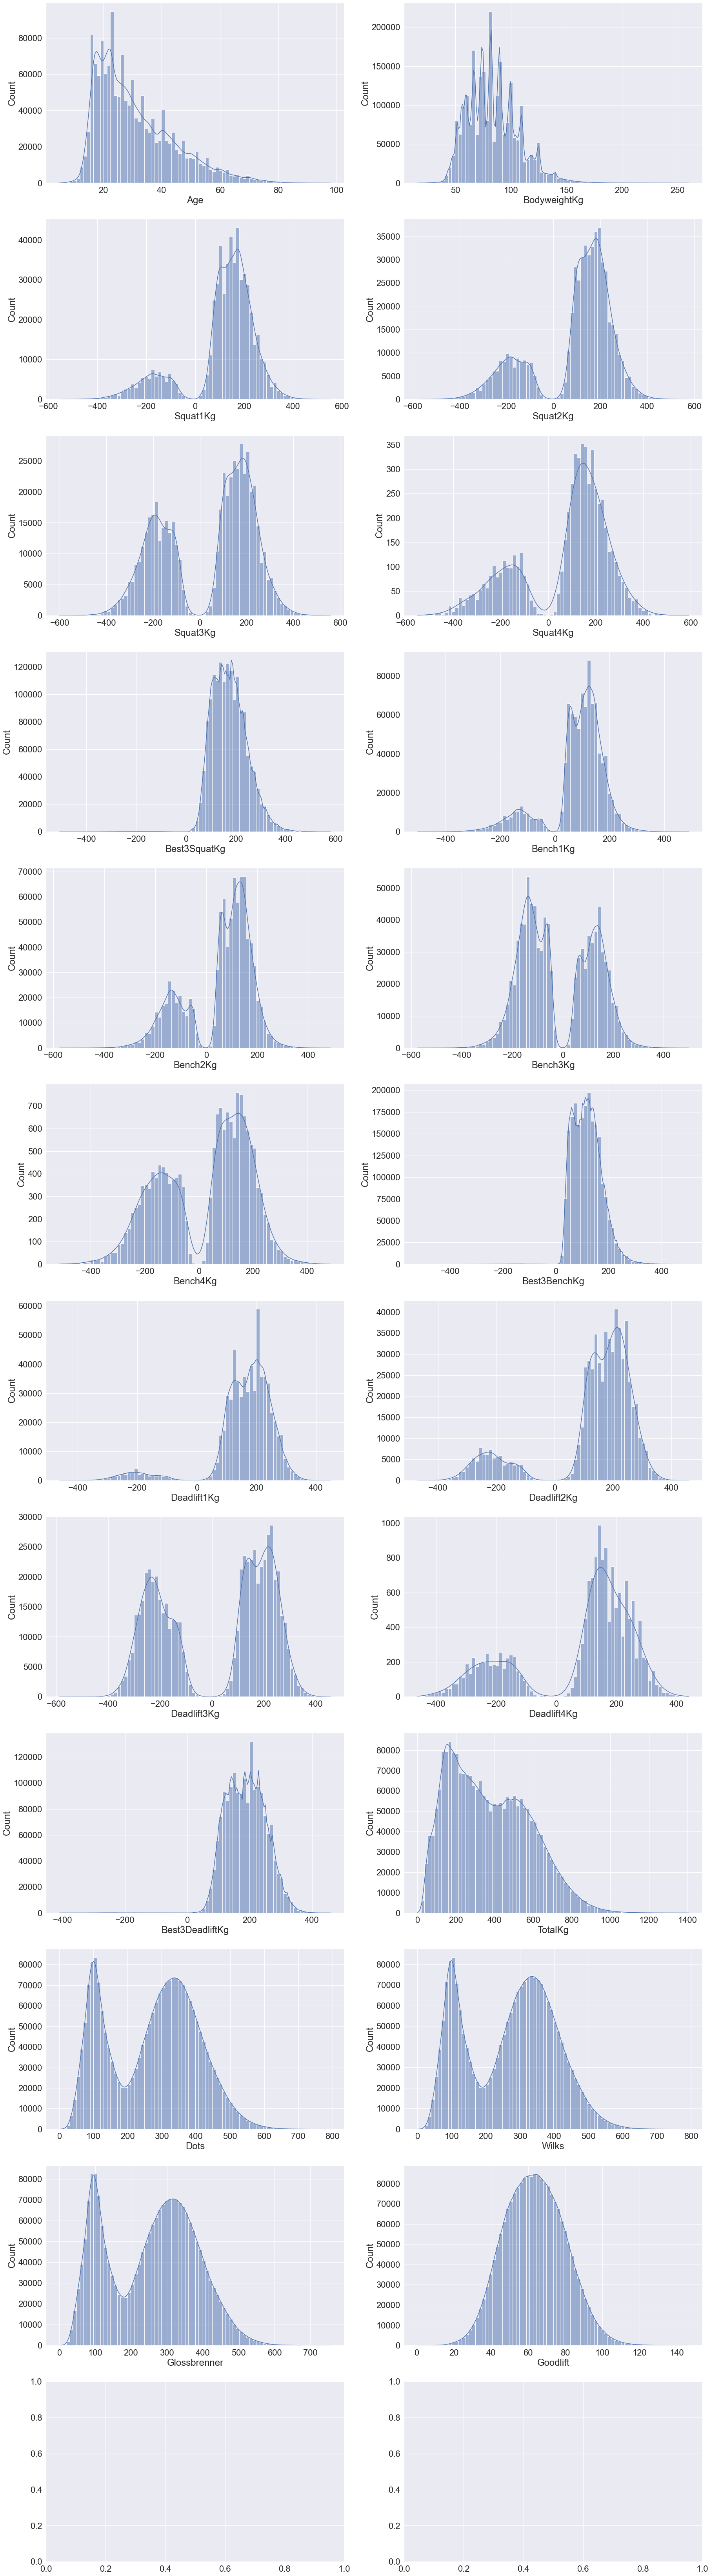

In [13]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(nrows = 1 + len(Xnum.columns)//2, ncols = 2, figsize = (30, 120))
for i, col in enumerate(Xnum.columns):
    sns.histplot(data = Xnum[col], ax = ax[i//2][i%2], bins = 80, kde = True)
plt.show()

#### **Observations:**
- Age is positively skewed and possibly bimodal
- Bodyweights are systemically multi-modal, likely set at weight class limits
- The relative frequency of missed lifts increases with attempts, except for 4th attempts
- 3rd attempt bench press seems to be missed more often than made (only lift with this behaviour)
- All lift attempt distributions have an identical feature - each "peak" has 2 "mini-peaks" (male/female?)
- Total has a unique distribution. The right side (>600kg) looks very "smooth". I suspect this is a single normal distribution "peaking out"
- Dots, Wilks and Glossbrenner metrics have very similar distributions - Looks like 2 normal distributions, one with a mode of 100 likely from bench-only events
- Goodlift is almost perfectly normally-distributed it seems

*Categorical variable distributions:*

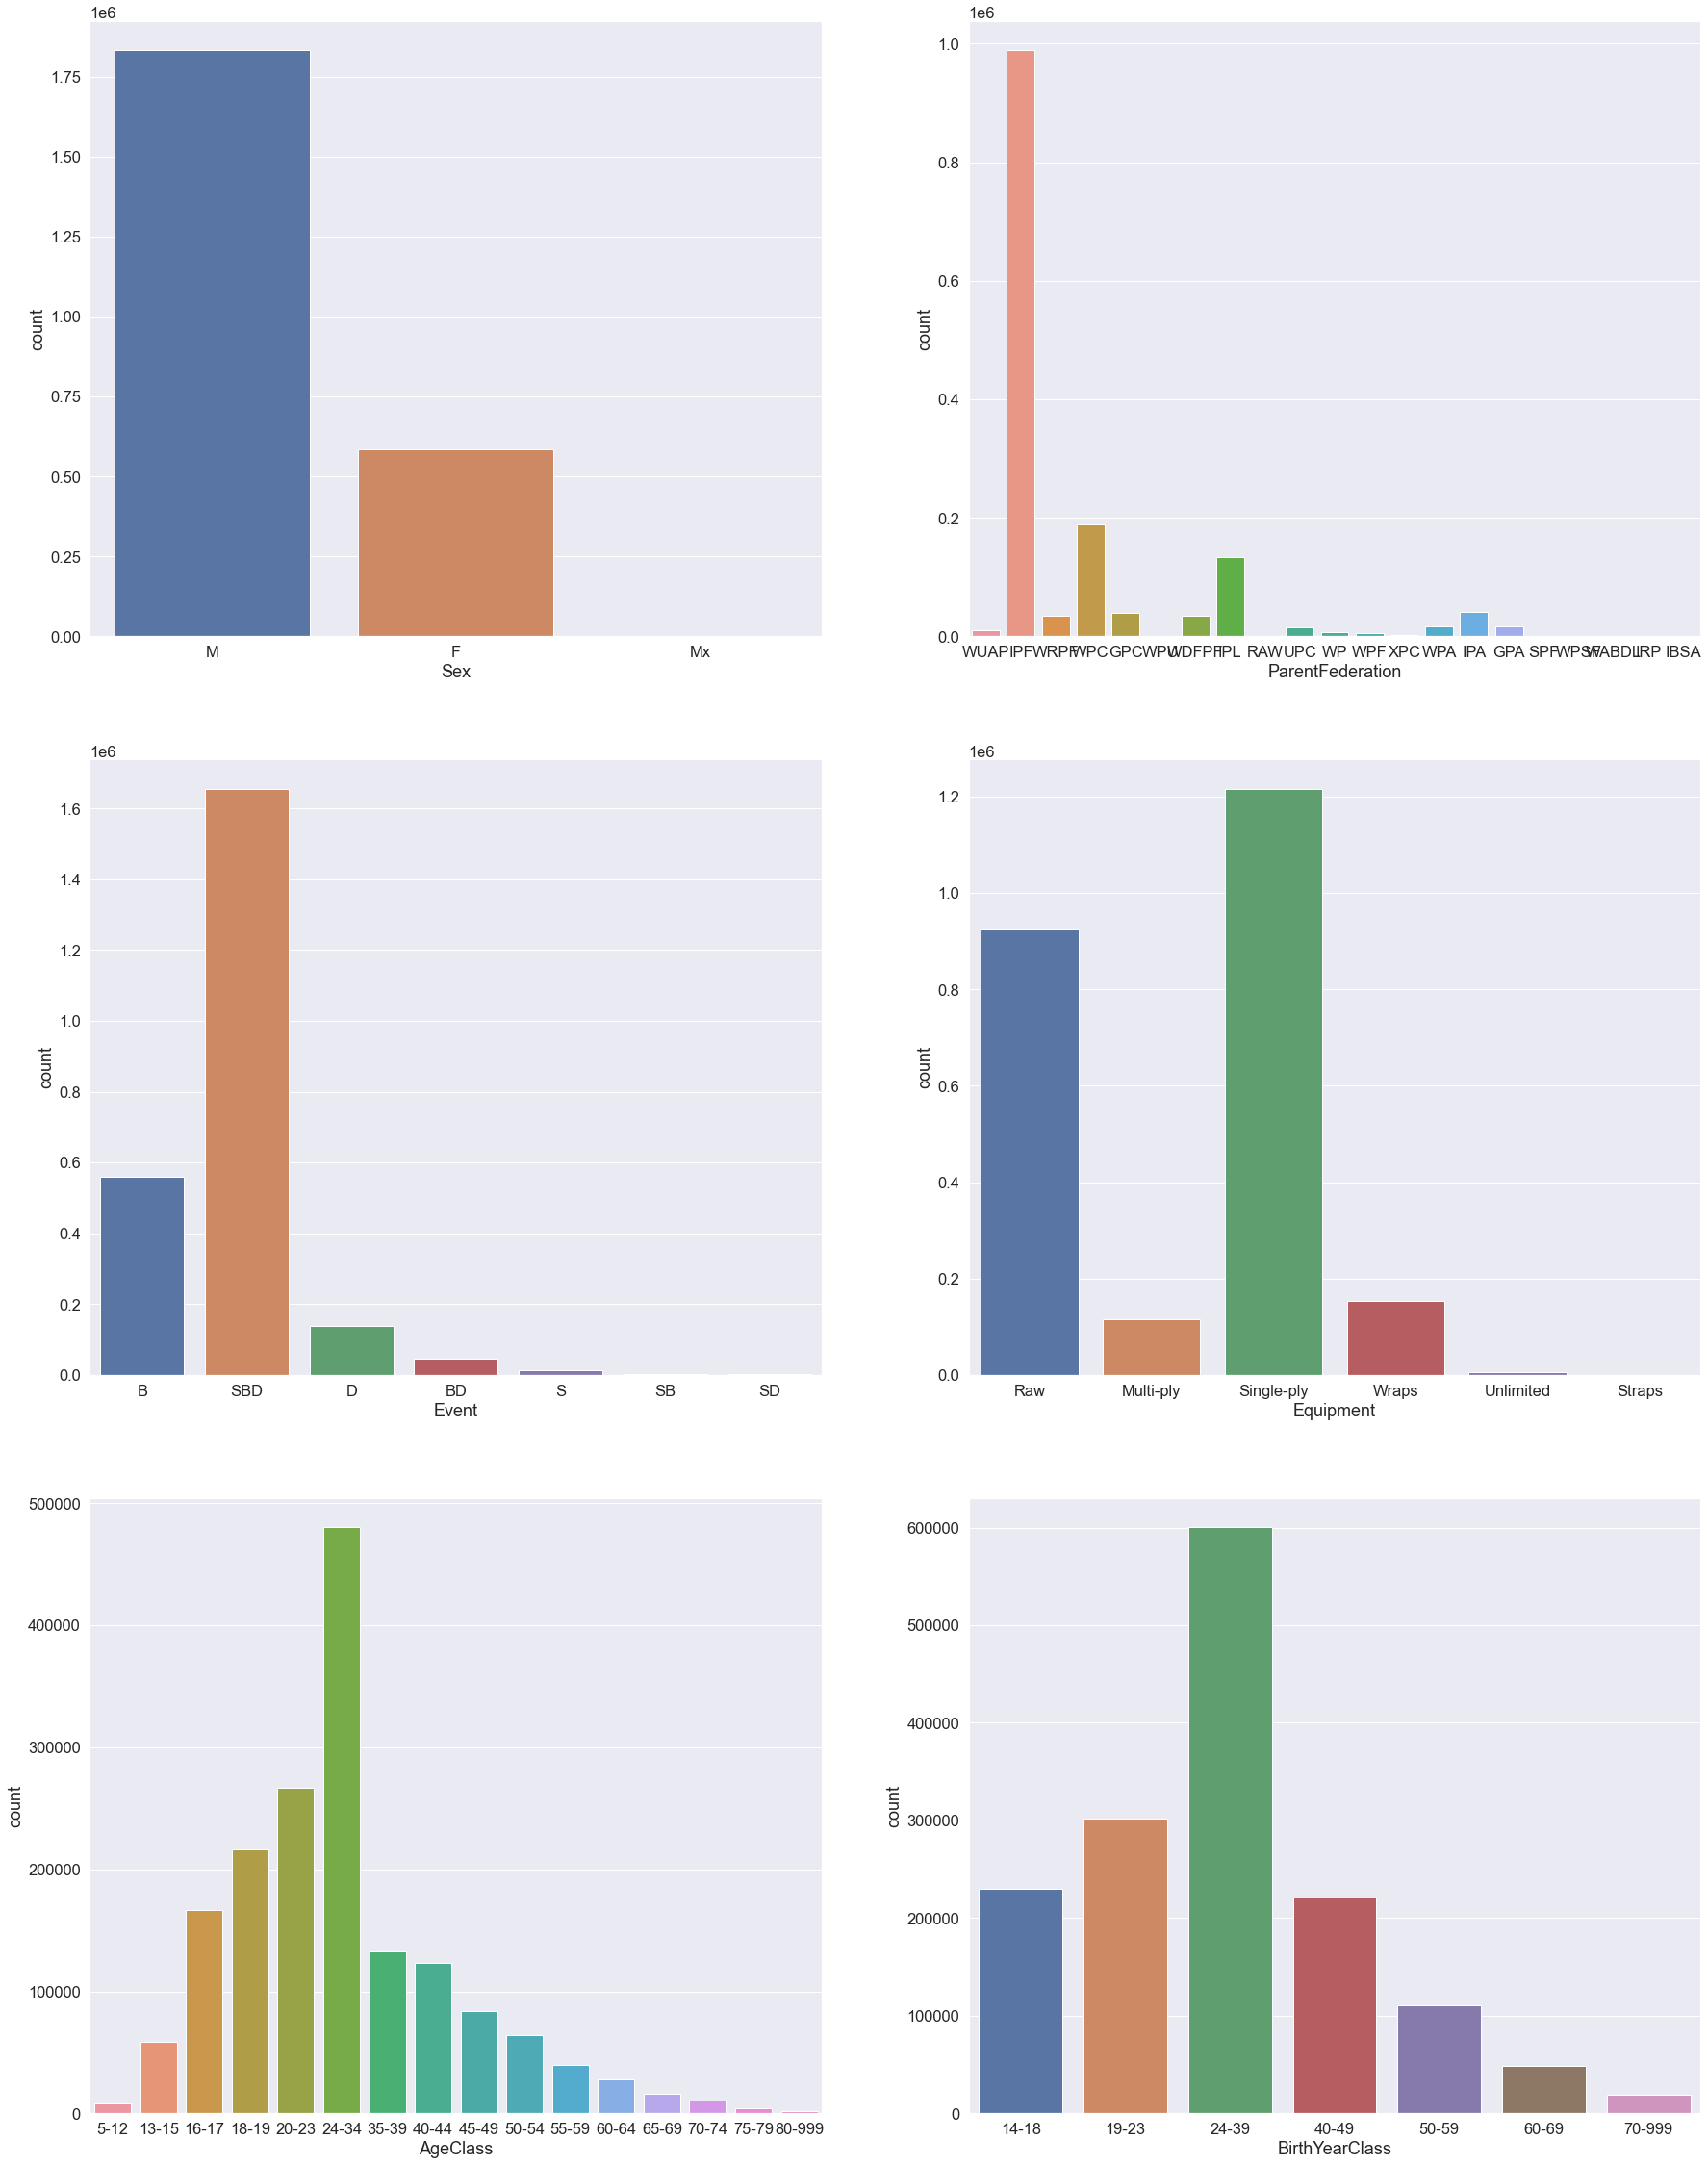

In [14]:
AgeClass_order = ['5-12', '13-15', '16-17', '18-19', '20-23', '24-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-999']
BirthYearClass_order = ['14-18', '19-23', '24-39', '40-49', '50-59', '60-69', '70-999']

sns.set(font_scale=1.5)
plt.figure(figsize=(30,40))

for i, col in enumerate(['Sex', 'ParentFederation', 'Event', 'Equipment']):
    axi = plt.subplot(3, 2, i + 1)
    sns.countplot(Xcat[col], ax = axi)
axi = plt.subplot(3, 2, 5)
sns.countplot(Xcat['AgeClass'], ax = axi, order = AgeClass_order)
axi = plt.subplot(3, 2, 6)
sns.countplot(Xcat['BirthYearClass'], ax = axi, order = BirthYearClass_order)

plt.show()

**Observations:**
- ~3x more males than females
- IPF is by far the dominant parent federation
- Event type popularity decreases by a factor of ~3 for each subsequent event in the order
- Single ply is more popular than raw (surprising) but multiply is signficantly less popular
- Age is positively skewed, as expected
- Although 24-34 is the largest age bracket, it also has the widest range

*Comp. popularity over time:*

<AxesSubplot:title={'center':'Competition count per year'}, ylabel='count'>

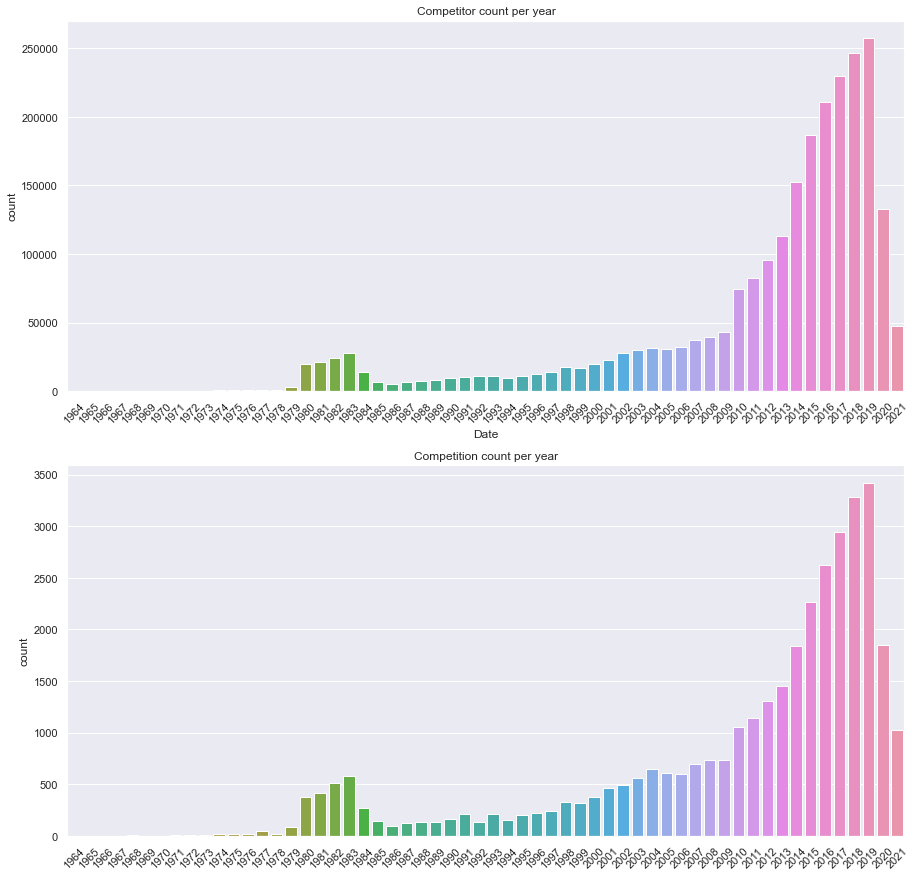

In [15]:
sns.set(font_scale = 1)
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15))
ax[0].set(title = 'Competitor count per year')
ax[1].set(title = 'Competition count per year')
plt.setp(ax[0].get_xticklabels(), rotation=45)
plt.setp(ax[1].get_xticklabels(), rotation=45)
sns.countplot(Xcat.Date.str[:4].astype(int), ax = ax[0])
sns.countplot([int(i[:4]) for i in np.concatenate(Xcat.groupby(['MeetName'])['Date'].unique().to_list())], ax = ax[1])

**Observations:**
- General trend of powerlifting popularity is exponential
- Competitions/competitors increasing in tandom
- Sharp decrease in popularity in 2020 (COVID)
- Interesting popularity shifts in the early 1980s

### Multivariate analysis

*Numeric variable correlations:*

<AxesSubplot:>

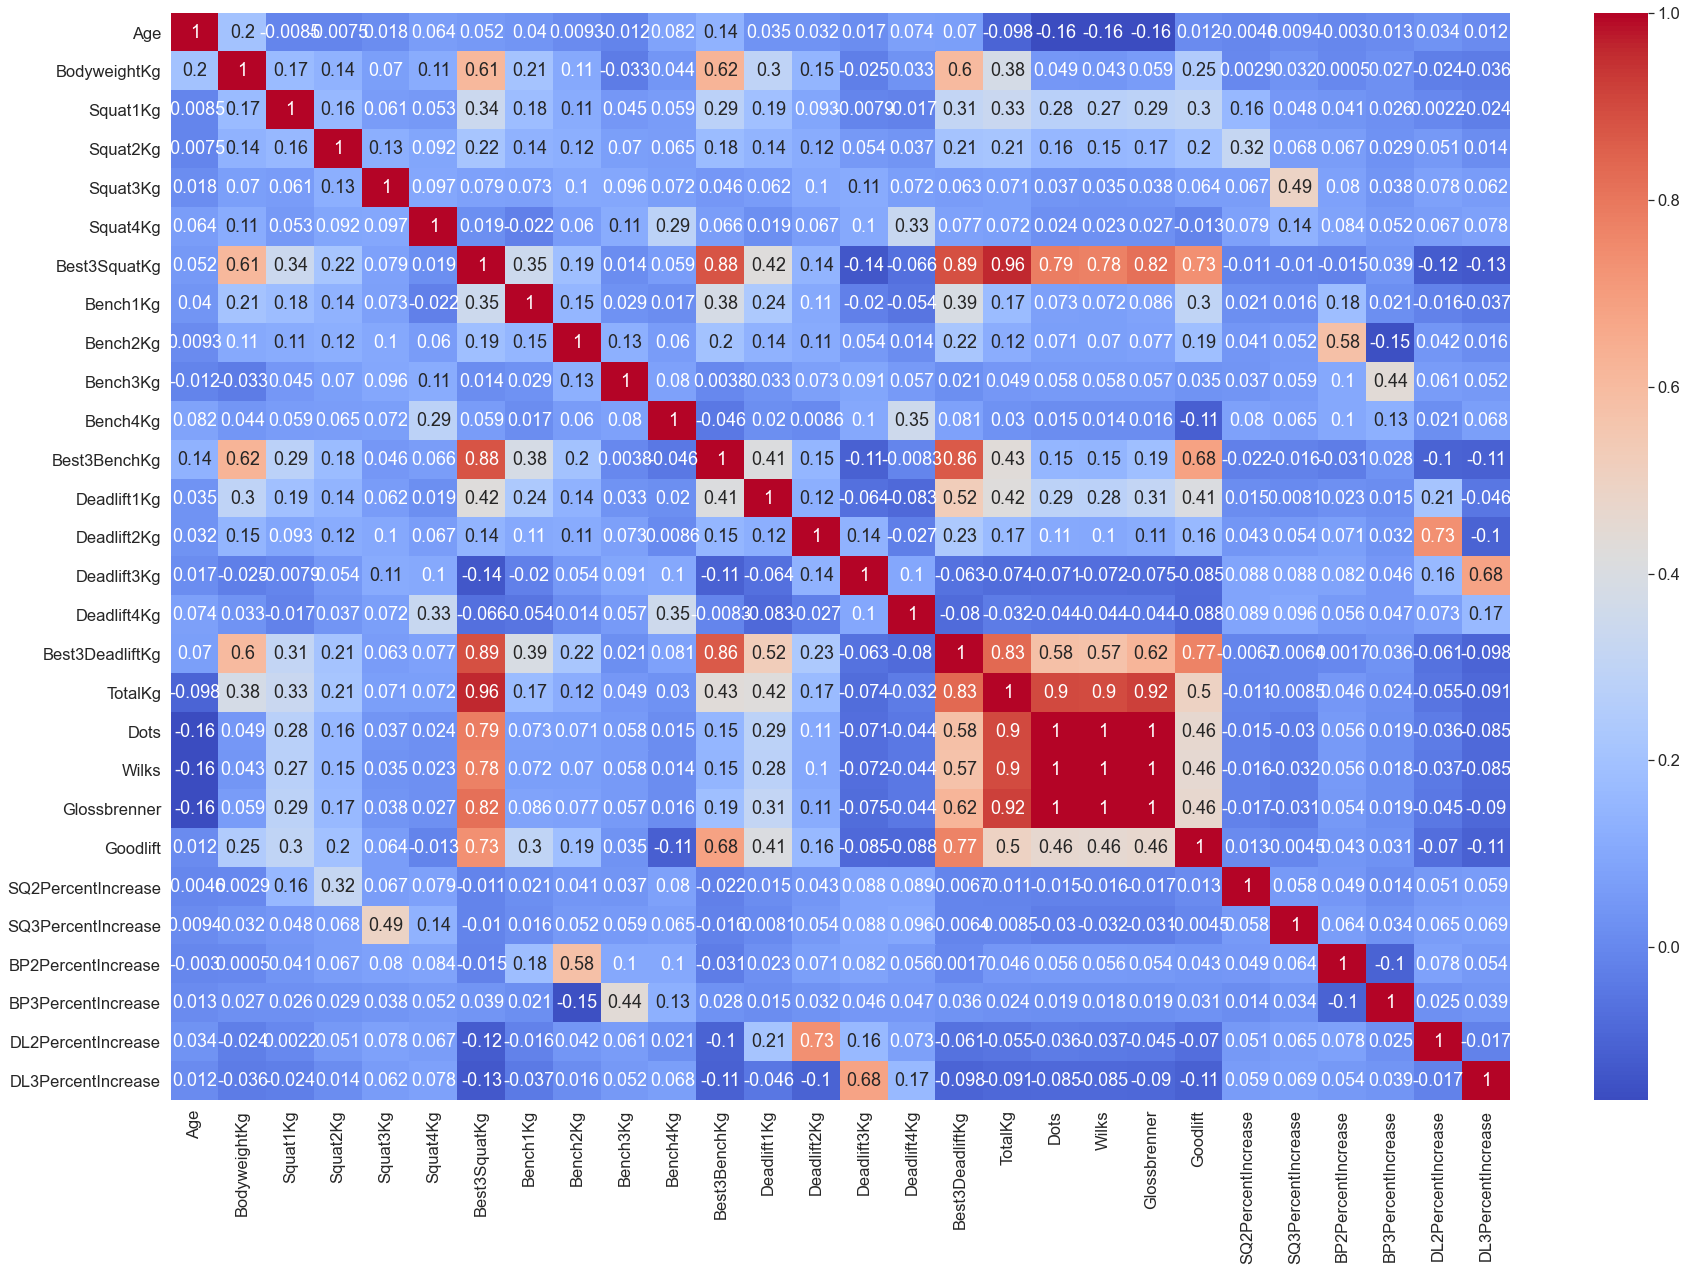

In [37]:
sns.set(font_scale = 1.5)
plt.figure(figsize=(30,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')

In [106]:
dftemp = df.copy()
dftemp['SQ2PercentIncrease'] = df.Squat2Kg / df.Squat1Kg - 1
dftemp['SQ3PercentIncrease'] = abs(df.Squat3Kg) / abs(df.Squat2Kg) - 1
dftemp['BP2PercentIncrease'] = df.Bench2Kg / df.Bench1Kg - 1
dftemp['BP3PercentIncrease'] = abs(df.Bench3Kg) / abs(df.Bench2Kg) - 1
dftemp['DL2PercentIncrease'] = df.Deadlift2Kg / df.Deadlift1Kg - 1
dftemp['DL3PercentIncrease'] = df.Deadlift3Kg / df.Deadlift2Kg - 1

In [112]:
dftemp2 = pd.DataFrame()
A = dftemp[(dftemp.Bench2Kg > 0) & (dftemp.Bench3Kg > 0)].BP3PercentIncrease
B = dftemp[(dftemp.Bench2Kg > 0) & (dftemp.Bench3Kg < 0)].BP3PercentIncrease

<AxesSubplot:ylabel='Count'>

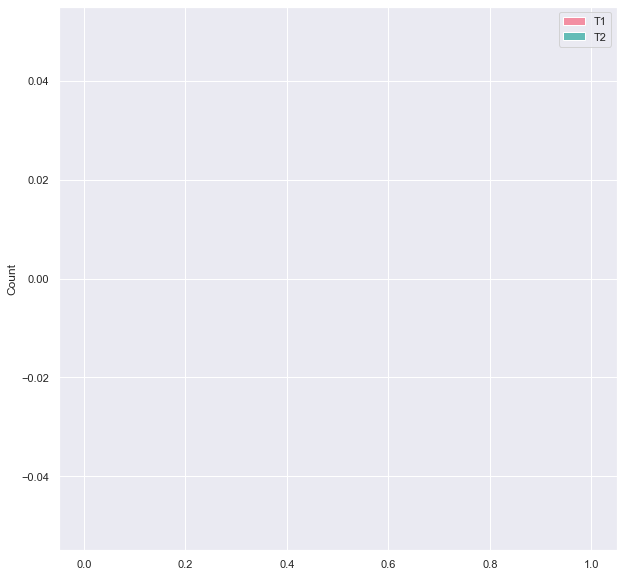

In [98]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.color_palette("light:#5A9", as_cmap=True)
sns.histplot(data = dftemp[['T1', 'T2']], bins = 40, palette = "husl")

In [77]:
#df[~df.Place.isin(["1", "2", "3", "4", "5", "DQ"])].index
dftemp.loc[dftemp[~dftemp.Place.isin([1, 2, 3, 4, 5, "DQ"])].index, 'Place'] = 'N'
ax = sns.boxplot(x="Place", y="SQ3PercentIncrease", data=dftemp)

KeyboardInterrupt: 

# TESTING AREA

In [18]:
help(ax[0].xaxis.set)

Help on method set in module matplotlib.artist:

set(**kwargs) method of matplotlib.axis.XAxis instance
    A property batch setter.  Pass *kwargs* to set properties.



In [19]:
a = df.groupby(['MeetName'])['Date'].unique().to_list()

In [20]:
a

[array(['2015-05-16'], dtype=object),
 array(['2001-05-26'], dtype=object),
 array(['2009-01-17'], dtype=object),
 array(['2009-01-17'], dtype=object),
 array(['2006-11-18'], dtype=object),
 array(['2018-08-14'], dtype=object),
 array(['2017-03-11'], dtype=object),
 array(['2016-01-16', '2013-01-26'], dtype=object),
 array(['2018-09-08'], dtype=object),
 array(['2018-01-12'], dtype=object),
 array(['2020-01-11', '2014-01-25'], dtype=object),
 array(['2018-01-20', '2017-01-21', '2014-01-25', '2015-01-24',
        '2016-01-23'], dtype=object),
 array(['2018-08-25', '2019-08-24'], dtype=object),
 array(['2019-02-02'], dtype=object),
 array(['2020-02-01'], dtype=object),
 array(['2019-04-27'], dtype=object),
 array(['2013-08-31'], dtype=object),
 array(['2011-02-05'], dtype=object),
 array(['2019-02-09'], dtype=object),
 array(['2020-01-18', '2019-01-19'], dtype=object),
 array(['2018-10-13'], dtype=object),
 array(['2014-02-22'], dtype=object),
 array(['2019-02-09'], dtype=object),
 array

In [21]:
[int(i[:4]) for i in np.concatenate(df.groupby(['MeetName'])['Date'].unique().to_list())]

[2015,
 2001,
 2009,
 2009,
 2006,
 2018,
 2017,
 2016,
 2013,
 2018,
 2018,
 2020,
 2014,
 2018,
 2017,
 2014,
 2015,
 2016,
 2018,
 2019,
 2019,
 2020,
 2019,
 2013,
 2011,
 2019,
 2020,
 2019,
 2018,
 2014,
 2019,
 2019,
 2014,
 2017,
 2001,
 2017,
 2014,
 2020,
 2019,
 2016,
 2013,
 2014,
 1998,
 2018,
 2019,
 2019,
 2011,
 2018,
 2003,
 2001,
 2018,
 2015,
 2020,
 2014,
 2015,
 2020,
 2015,
 2019,
 2013,
 2021,
 2019,
 2016,
 2001,
 2015,
 2001,
 2019,
 2016,
 2015,
 2016,
 2017,
 2014,
 2016,
 2016,
 2017,
 2013,
 2014,
 2014,
 2014,
 2017,
 2006,
 2012,
 2005,
 2013,
 2018,
 2007,
 2017,
 2011,
 2015,
 2015,
 2020,
 2019,
 2012,
 2014,
 2016,
 2015,
 2019,
 2015,
 2014,
 2008,
 2006,
 2017,
 2013,
 2018,
 2012,
 2020,
 2017,
 2013,
 2015,
 2010,
 2020,
 2019,
 2020,
 2019,
 2015,
 2018,
 2014,
 2016,
 2019,
 2018,
 1983,
 1982,
 2001,
 2001,
 2001,
 2001,
 2001,
 2019,
 2015,
 2017,
 2019,
 2016,
 2019,
 2019,
 2018,
 2004,
 2010,
 2014,
 2020,
 2010,
 2013,
 2009,
 2008,
 2012,

<AxesSubplot:xlabel='Event', ylabel='count'>

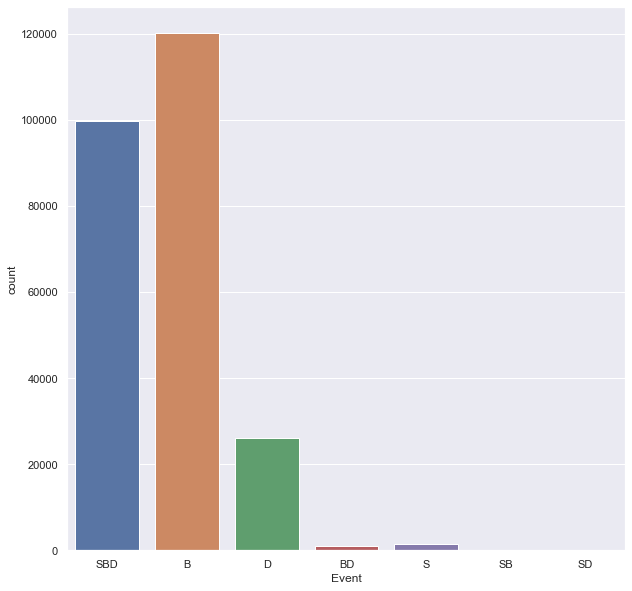

In [22]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.countplot(data = df[df['Country'].isin(['Russia'])], x = 'Event')

<AxesSubplot:xlabel='Event', ylabel='count'>

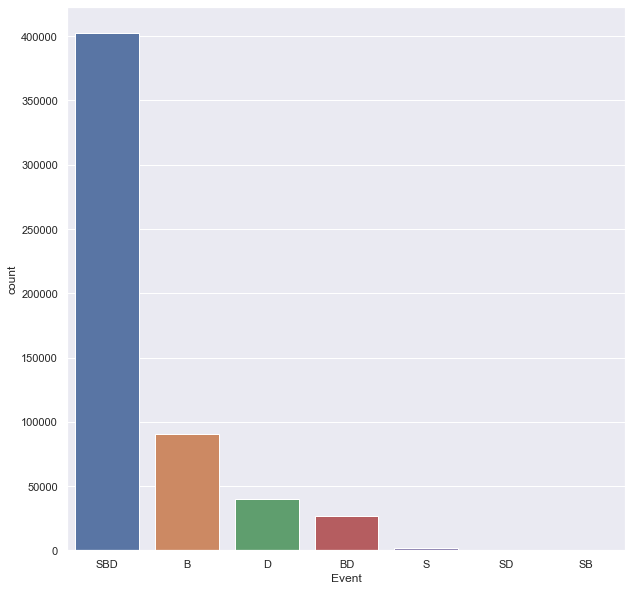

In [23]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.countplot(data = df[df['Country'].isin(['USA'])], x = 'Event')

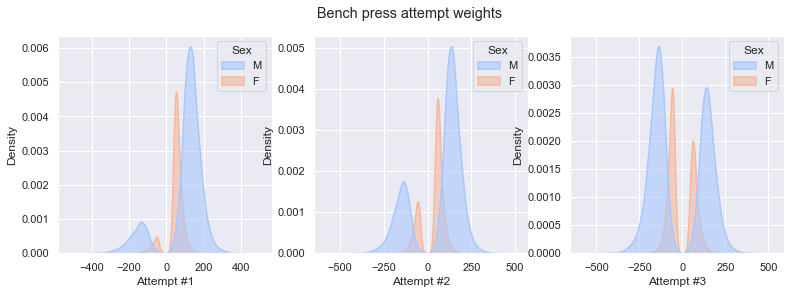

In [76]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (13, 4))
sns.set(font_scale=1)
#sns.histplot(data = Xnum.Bench1Kg, bins = 80, color = "orange", ax = ax[0])
#sns.histplot(data = Xnum.Bench2Kg, bins = 80, color = "darkorange", ax = ax[1])
#sns.histplot(data = Xnum.Bench3Kg, bins = 80, color = "red", ax = ax[2])
sns.kdeplot(data = df[['Bench1Kg', 'Sex']], x = 'Bench1Kg', fill = True, palette = "coolwarm", alpha = 0.6, linewidth = 1.5, hue = 'Sex', ax = ax[0])
sns.kdeplot(data = df[['Bench2Kg', 'Sex']], x = 'Bench2Kg', fill = True, palette = "coolwarm", alpha = 0.6, linewidth = 1.5, hue = 'Sex', ax = ax[1])
sns.kdeplot(data = df[['Bench3Kg', 'Sex']], x = 'Bench3Kg', fill = True, palette = "coolwarm", alpha = 0.6, linewidth = 1.5, hue = 'Sex', ax = ax[2])
fig.suptitle('Bench press attempt weights')
ax[0].set(xlabel='Attempt #1')
ax[1].set(xlabel='Attempt #2')
ax[2].set(xlabel='Attempt #3')
fig.savefig("../../Output/bench_attempt_frequencies.png",dpi=80)

In [67]:
fig.savefig("../../Output/bench_attempt_frequencies.png",dpi=50)

<Figure size 1080x360 with 0 Axes>

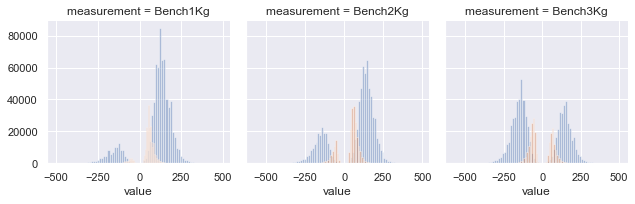

In [28]:
plt.figure(figsize = (15, 5))
sns.set(font_scale=1)
sns.color_palette("flare", as_cmap=True)
iris_long = pd.melt(df[['Bench1Kg', 'Bench2Kg', 'Bench3Kg', 'Sex']], "Sex", var_name="measurement")
g = sns.FacetGrid(iris_long, hue="Sex", col="measurement", col_wrap=3, sharex=False)
g.map(plt.hist, "value", alpha=.4, bins = 80)

C:\Users\Joe\anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\Joe\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-26-d0b82b5b398e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

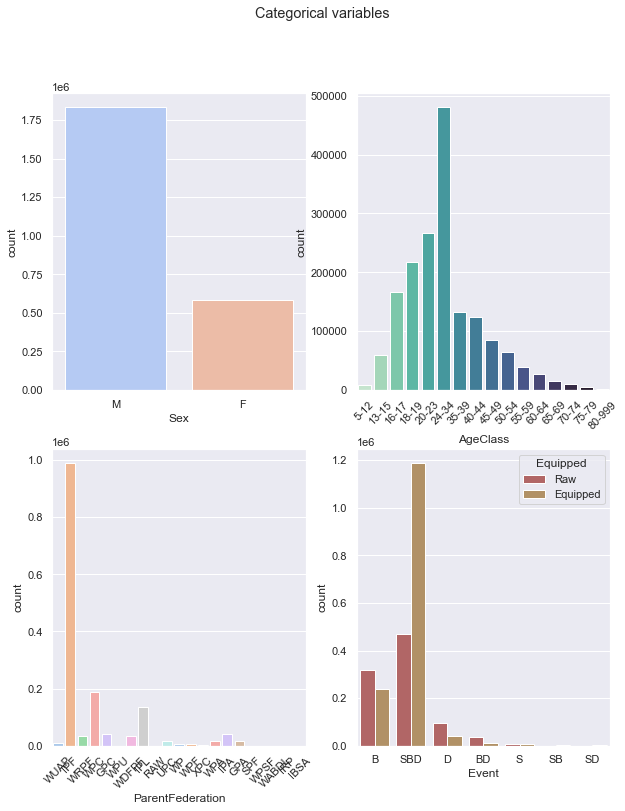

In [26]:
AgeClass_order = ['5-12', '13-15', '16-17', '18-19', '20-23', '24-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-999']
BirthYearClass_order = ['14-18', '19-23', '24-39', '40-49', '50-59', '60-69', '70-999']

sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 12))
plt.setp(ax[0][1].get_xticklabels(), rotation=45)
plt.setp(ax[1][0].get_xticklabels(), rotation=45)
fig.suptitle('Categorical variables')

sns.countplot(Xcat.Sex, ax = ax[0][0], palette = "coolwarm")
sns.countplot(Xcat['AgeClass'], ax = ax[0][1], order = AgeClass_order, palette = "mako_r")
sns.countplot(Xcat.ParentFederation, ax = ax[1][0], palette = "pastel")
Xcat.loc[:, 'Equipped'] = 'Raw'
Xcat.loc[Xcat['Equipment'] != 'Raw', 'Equipped'] = 'Equipped'
sns.countplot(data = Xcat, x = "Event", hue = "Equipped", palette = ["#bd5959", "#bd9359"], ax = ax[1][1])

fig.savefig("../../Output/cat_vars.png",dpi=100)

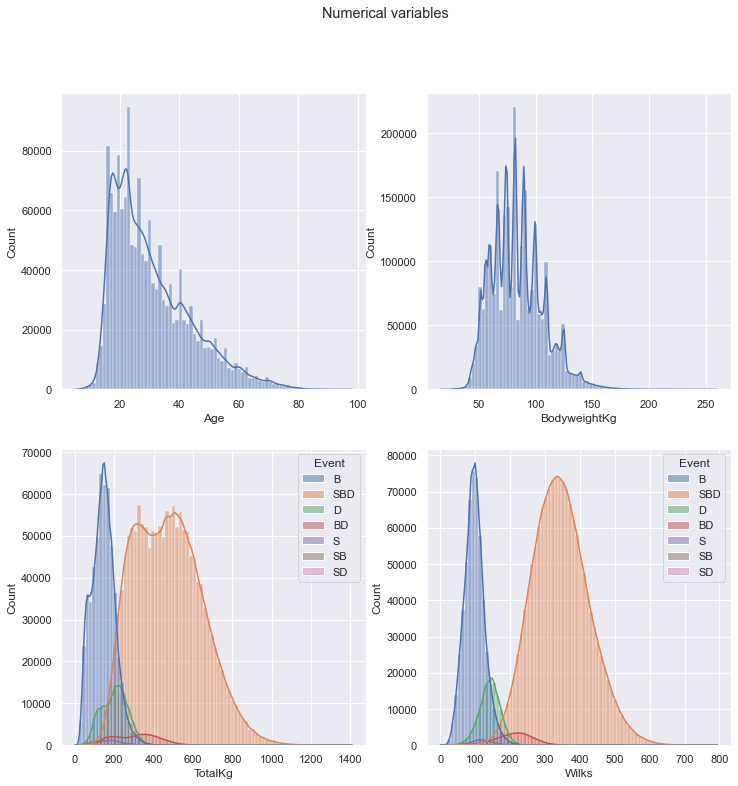

In [33]:
sns.set(font_scale=1)
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 12))
fig.suptitle('Numerical variables')
sns.histplot(data = Xnum, x = 'Age', ax = ax[0][0], bins = 80, kde = True)
sns.histplot(data = Xnum, x = 'BodyweightKg', ax = ax[0][1], bins = 80, kde = True)
sns.histplot(data = df, x = 'TotalKg', hue = 'Event', ax = ax[1][0], bins = 80, kde = True)
sns.histplot(data = df, x = 'Wilks', hue = 'Event', ax = ax[1][1], bins = 80, kde = True)

fig.savefig("../../Output/num_vars.png",dpi=100)